In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

In [2]:
# Load the interpolated data
dataset = pd.read_pickle("StudyRegionTraining.pkl")
le = LabelEncoder()
dataset['class'] = le.fit_transform(dataset['class'])

In [3]:
print(dataset)

            0     1     2      3     4     5      6     7     8      9  ...  \
0       14985  8739  1065  14985  8739  1065  14985  8739  1065  12682  ...   
1       14679  8629  1063  14679  8629  1063  14679  8629  1063  12943  ...   
2       14603  8732  1063  14603  8732  1063  14603  8732  1063  12909  ...   
3       14591  8810  1062  14591  8810  1062  14591  8810  1062  12870  ...   
4       14631  8663  1061  14631  8663  1061  14631  8663  1061  12501  ...   
...       ...   ...   ...    ...   ...   ...    ...   ...   ...    ...  ...   
254969  15510  8633   199  15510  8633   199  15510  8633   199  16316  ...   
254970  15658  8939   200  15658  8939   200  15658  8939   200  15900  ...   
254971  14679  9024   186  14679  9024   186  14679  9024   186  20029  ...   
254972  14559  8986   187  14559  8986   187  14559  8986   187  19252  ...   
254973  14991  9292   187  14991  9292   187  14991  9292   187  17472  ...   

          657    658   659    660    661   662    6

In [4]:
# Train and test split
train, test = train_test_split(dataset, test_size=0.1,shuffle=True)
train, val = train_test_split(train, test_size=0.25,shuffle=True)

In [5]:
# sc_x = StandardScaler()
# train_scaled = pd.DataFrame(sc_x.fit_transform(train.T).T,columns=train.columns)
# val_scaled = pd.DataFrame(sc_x.fit_transform(val.T).T,columns=val.columns)
# test_scaled=pd.DataFrame(sc_x.fit_transform(test.T).T,columns=test.columns)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
device

device(type='cuda', index=0)

In [7]:
seq_len = 222
bands = 3
# Train loader
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_Train_tensors = Variable(torch.Tensor(x_train.to_numpy()))
Y_Train_tensors = Variable(torch.Tensor(y_train.to_numpy()))
X_train_tensors_final = torch.reshape(X_Train_tensors, (X_Train_tensors.shape[0],seq_len,bands)).to(device)
Y_train_tensors_final = Y_Train_tensors.to(device)
train_dataset = TensorDataset(X_train_tensors_final,Y_train_tensors_final) # create your datset
train_loader = DataLoader(train_dataset,batch_size=32) # create your dataloader

In [8]:
# Val loader
x_val = val.iloc[:,:-1]
y_val = val.iloc[:,-1]
X_val_tensors = Variable(torch.Tensor(x_val.to_numpy()))
Y_val_tensors = Variable(torch.Tensor(y_val.to_numpy()))
X_val_tensors_final = torch.reshape(X_val_tensors, (X_val_tensors.shape[0],seq_len,bands)).to(device)
Y_val_tensors_final = Y_val_tensors.to(device)
val_dataset = TensorDataset(X_val_tensors_final,Y_val_tensors_final) # create your datset
val_loader = DataLoader(val_dataset,batch_size=32) # create your dataloader

In [9]:
# test loader
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
X_test_tensors = Variable(torch.Tensor(x_test.to_numpy()))
Y_test_tensors = Variable(torch.Tensor(y_test.to_numpy()))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],seq_len,bands)).to(device)
# Y_train_tensors_final = torch.reshape(Y_Train_tensors, (Y_Train_tensors.shape[0], 1)).to(device)
Y_test_tensors_final = Y_test_tensors.to(device)
test_dataset = TensorDataset(X_test_tensors_final,Y_test_tensors_final) # create your datset
test_loader = DataLoader(test_dataset,batch_size=32) # create your dataloader

In [12]:
# LSTM network
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        self.batchNorm = nn.BatchNorm1d(seq_length)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
#         self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size,num_classes)
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_().to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).requires_grad_().to(device) #internal state
        # Propagate input through LSTM
        norm = self.batchNorm(x)
#         print(norm)
        output, (hn, cn) = self.lstm(norm, (h_0, c_0)) #lstm with input, hidden, and internal state
#         out,_ = torch.max(output,dim=1)
        out = self.fc(output[:,-1,:])
#         hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
#         out = self.relu(hn)
#         out = self.fc_1(out) #first Dense
#         out = self.relu(out) #relu
#         out = self.fc(out) #Final Output
        return out

In [13]:
# Parameters
num_epochs = 1 # epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 100 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = 9 #number of output classes 

In [14]:
# Initialize the model and optimizer
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
lstm1.to(device)#our lstm class 
# criterion = torch.nn.MSELoss() # mean-squared error for regression
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm1.parameters(), lr=learning_rate,momentum=0.9)

In [17]:
# Train the model
train_losses = []
val_losses = []
tb = SummaryWriter("runs4")
for epoch in range(num_epochs):
    batch_losses = []
    train_acc = 0.0
    lstm1.train()
    for inputs,labels in train_loader:
        inputs,labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        outputs = lstm1(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_train_loss = np.mean(batch_losses)
    tb.add_scalar("Training_Loss", epoch_train_loss, epoch)
    train_losses.append(epoch_train_loss)
    lstm1.eval()
    with torch.no_grad():
        batch_val_losses = []
        for x_val,y_val in val_loader:
            x_val,y_val = x_val.to(device), y_val.to(device)
            y_val = y_val.long() 
            y_pred = lstm1(x_val)
            val_loss = criterion(y_pred,y_val)
            batch_val_losses.append(val_loss.item())
        validation_loss = np.mean(batch_val_losses)
        tb.add_scalar("Validation_Loss", validation_loss, epoch)
        val_losses.append(validation_loss)
    print(f"[{epoch}/{num_epochs}] Training loss: {epoch_train_loss:.4f}\t Validation loss: {validation_loss:.4f}")
torch.save(lstm1.state_dict(), 'StudyRegionModel.pth')
tb.close()

[0/80] Training loss: 0.3253	 Validation loss: 0.2093
[1/80] Training loss: 0.1420	 Validation loss: 0.0943
[2/80] Training loss: 0.0956	 Validation loss: 0.0738
[3/80] Training loss: 0.0714	 Validation loss: 0.0546
[4/80] Training loss: 0.0562	 Validation loss: 0.0412
[5/80] Training loss: 0.0455	 Validation loss: 0.0358
[6/80] Training loss: 0.0394	 Validation loss: 0.0312
[7/80] Training loss: 0.0348	 Validation loss: 0.0280
[8/80] Training loss: 0.0304	 Validation loss: 0.0234
[9/80] Training loss: 0.0273	 Validation loss: 0.0260
[10/80] Training loss: 0.0241	 Validation loss: 0.0213
[11/80] Training loss: 0.0222	 Validation loss: 0.0231
[12/80] Training loss: 0.0194	 Validation loss: 0.0189
[13/80] Training loss: 0.0183	 Validation loss: 0.0196
[14/80] Training loss: 0.0163	 Validation loss: 0.0202
[15/80] Training loss: 0.0153	 Validation loss: 0.0139
[16/80] Training loss: 0.0138	 Validation loss: 0.0133
[17/80] Training loss: 0.0127	 Validation loss: 0.0145
[18/80] Training los

Text(0.5, 1.0, 'Training Loss')

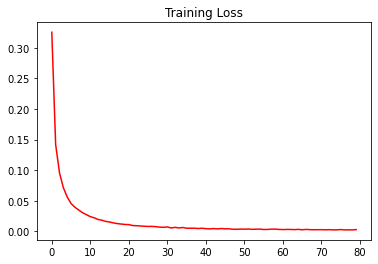

In [18]:
plt.plot(np.array(train_losses), 'r')
plt.title("Training Loss")

Text(0.5, 1.0, 'Validation Loss')

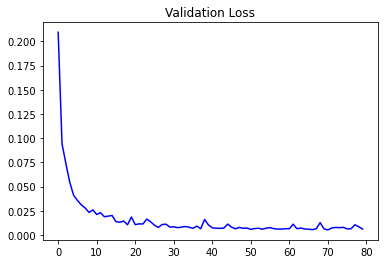

In [19]:
plt.plot(np.array(val_losses),'b')
plt.title("Validation Loss")

In [22]:
lstm1.eval()
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)
nb_classes = 9
confusion_mat = torch.zeros(nb_classes,nb_classes)
with torch.no_grad():
    for inputs,labels in test_loader:
        inputs,labels = inputs.to(device), labels.to(device)
        outputs = lstm1(inputs)
        _,predicted = torch.max(outputs.data,1)
        predlist = torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist,labels.view(-1).cpu()])
conf_mat = confusion_matrix(lbllist.numpy(),predlist.numpy())    

In [23]:
print(conf_mat)

array([[  165,     3,     0,     1,     0,     0,     1,     0,     0],
       [    0, 16295,     2,     0,     0,     0,     0,     0,     0],
       [    2,     7,   518,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,  1366,     2,     0,     0,     0,     0],
       [    0,     0,     0,     0,   101,     0,     0,     0,     0],
       [    3,     4,     1,     0,     1,  6608,     1,     0,     0],
       [    1,     0,     0,     0,     0,     1,   299,     1,     0],
       [    0,     0,     0,     0,     0,     0,     0,   109,     0],
       [    0,     0,     0,     0,     0,     2,     0,     0,     4]])

<AxesSubplot:>

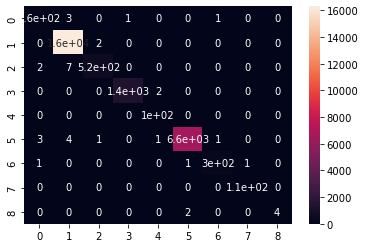

In [24]:
import seaborn as sns
sns.heatmap(conf_mat, annot=True)

In [25]:
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 97.05882353  99.9877278   98.29222011  99.85380117 100.
  99.84889695  99.00662252 100.          66.66666667]
